In [7]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [8]:
class ReplayBuffer:
    """
    经验回放池
    """
    def __init__(self, capacity):
        """
        初始化函数
        :param capacity: 存储量
        """
        self.buffer = collections.deque(maxlen=capacity)  # 双端队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)# 在经验池中随机采样
        state, action, reward, next_state, done = zip(*transitions)# 采样采出的是元组的列表, zip方法可以将元组中的每一项目在抽取出来组成新的列表
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [15]:
class Qnet(torch.nn.Module):
    """
    Q-Learning的神经网络, 这个任务不需要太大的网络规模
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

然后是整个DQN网络的流程, 我们要维护两个网络一个是$Q$网络使我们需要拟合的动作价值函数, 另一个是目标网络这个网络是拟合$\text{Q-Learning Target}$

在训练时每个$Q$网络的标签都是用$\text{Q-Learning Target}$生成, $\text{Q-Learning Target}$的参数是从$\text{Qnet}$拷贝过来的

In [42]:
class DQN:
    """
    DQN算法
    """
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        """
        
        :param state_dim: 编码状态的维度, 为一个一维向量
        :param hidden_dim: 神经网络的隐藏层维度
        :param action_dim: 编码动作的维度, 为一个一维向量
        :param learning_rate: 学习率
        :param gamma: 衰减因子
        :param epsilon: epsilon贪婪
        :param target_update: Q-Learning 的更新频率
        :param device: 是否使用cuda
        """
        self.action_dim = action_dim
        # Q网络
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器, 可以看到优化器仅仅将q_net进行优化
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数, 与target_update配合几个回合更新一次
        self.device = device

    def take_action(self, state):  # epsilon-greedy策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        
        # 将所有信息转化为tensor
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        # 计算q值, q_net 输入:[batch_size, state_dim]=>输出: [batch_size, num_actions]
        # .gather(1, actions)是从输出中选择对应action
        q_values = self.q_net(states).gather(1, actions)
        # target_q_net与q_net在输入输出上是一致的, 下个状态的最大Q值
        # 在动作维度上取最大值, [0]是从元组中提取值, 然后使用view函数变为形状为[batch_size, 1]的张量
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        # 根绝公式计算QLearning-target
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        # 计算损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:# 不会一直更新目标网络而是按照一定频率来更新
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 目标网络的参数优化直接复制q_net的参数
        self.count += 1

下面是加载必要的超参数的环境我们重点分析一下gym中的CartPole环境

1. env.step(action): 执行一个动作，返回环境的下一个状态、奖励、是否终止等信息 输出next_state, reward, 和done(当前episode是否结束)
2. env.render(): 可视化环境
3. env.close(): 关闭环境
4. env.observation_space: 环境的状态空间
5. env.action_space: 动作空间
6. env.reward_range: 奖励范围

In [43]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)# 加载CartPole场景
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
print(state_dim)
action_dim = env.action_space.n
print(action_dim)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

4
2


In [50]:
return_list = []
for i in range(100):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state, _= env.reset()
            done = False
            while not done:# 直到episode终止
                action = agent.take_action(state)# 智能体选择一个动作
                next_state, reward, done, _, _ = env.step(action)# 环境返回状态和即时奖励
                replay_buffer.add(state, action, reward, next_state, done)# 存入
                state = next_state
                episode_return += reward# 计算累计奖励
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 37:  40%|████      | 20/50 [01:38<02:28,  4.94s/it, episode=1870, return=1711.400]


KeyboardInterrupt: 

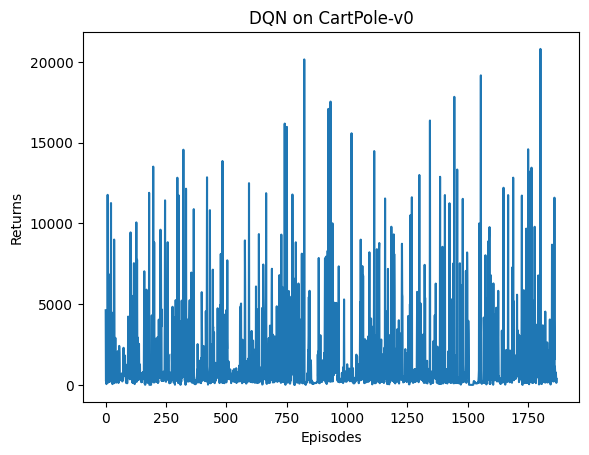

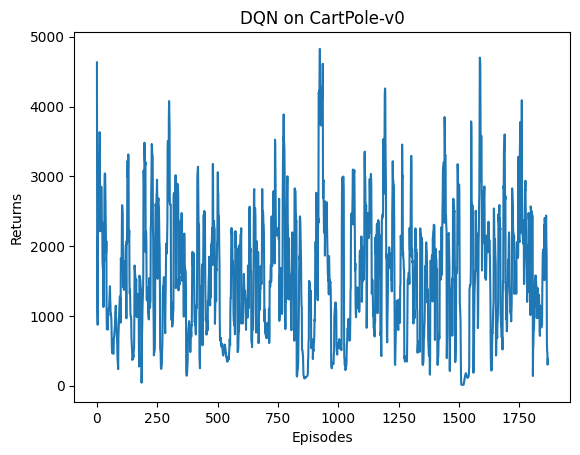

In [53]:
# return=200.000]
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()